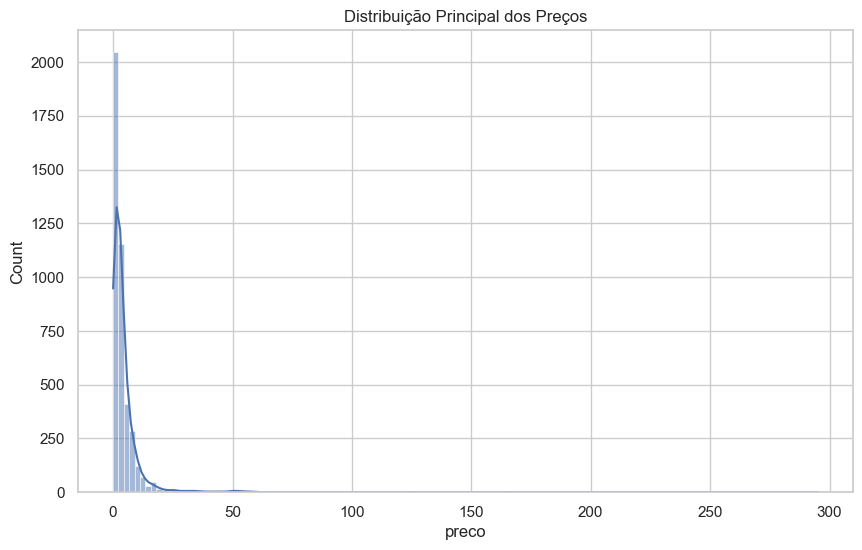

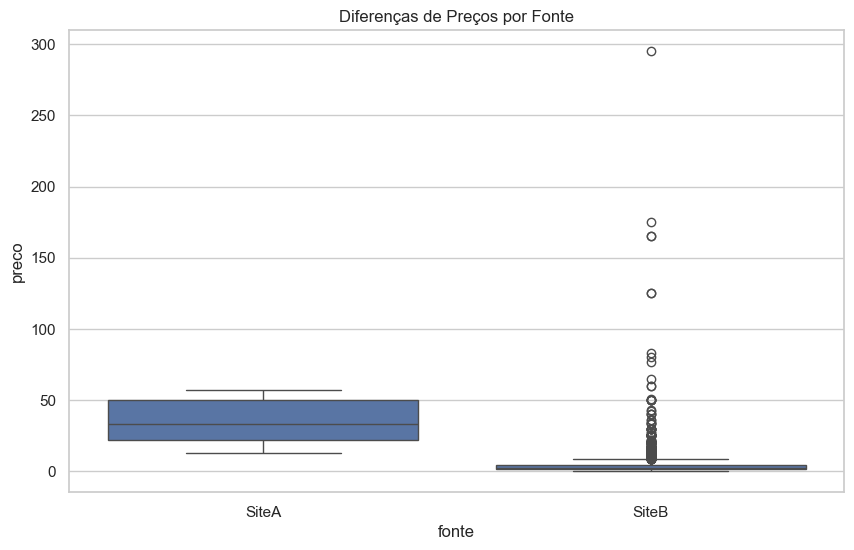

Teste t: 27.525242595072857, p-value: 1.0623983238131582e-153


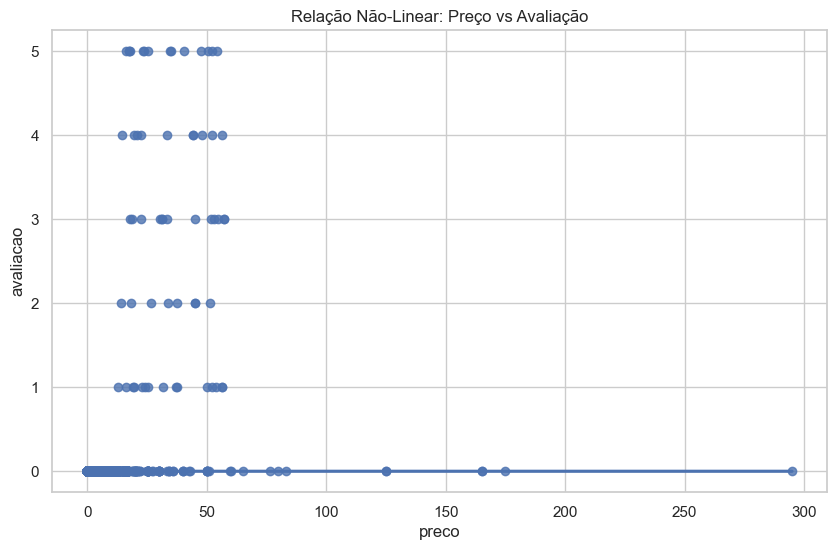

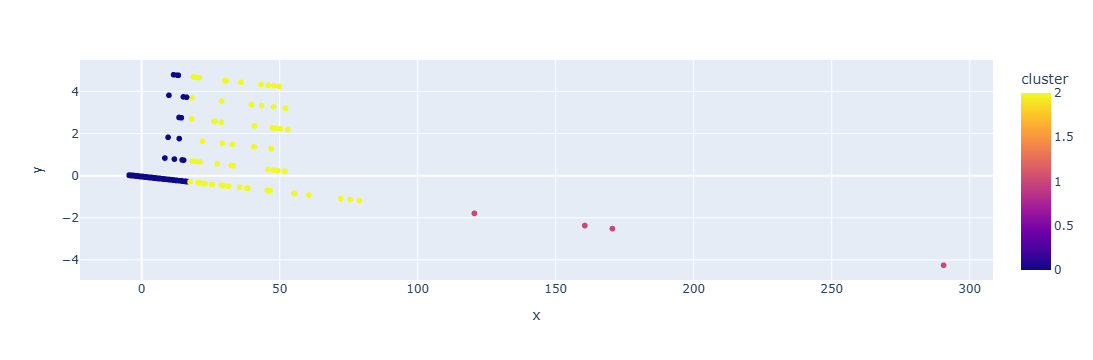

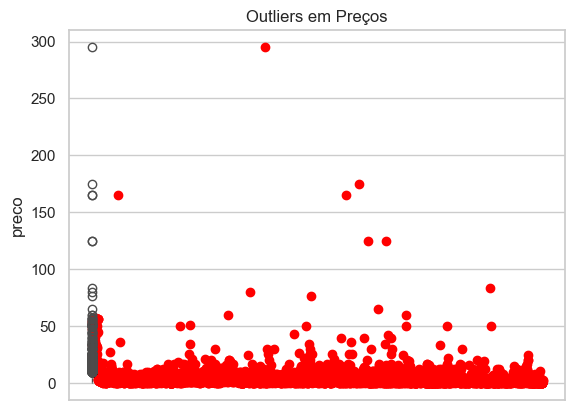

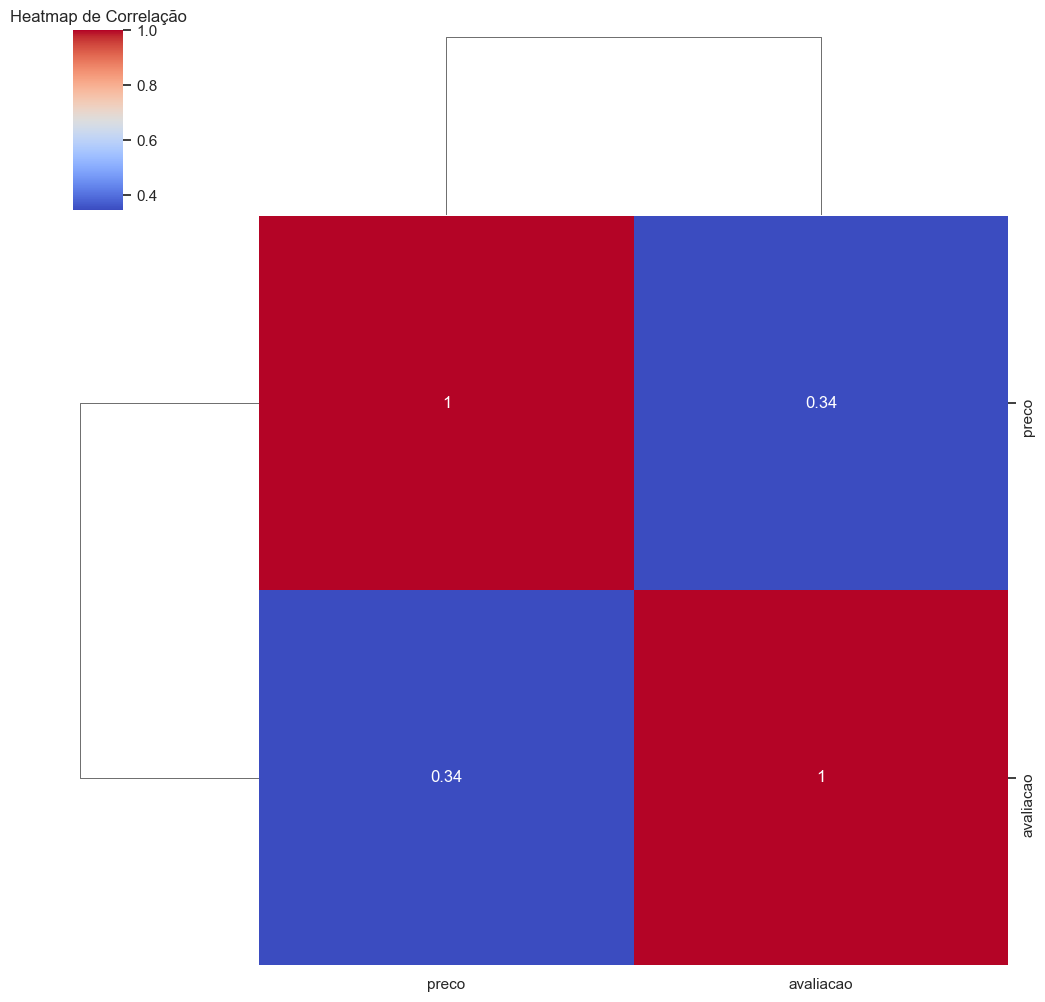

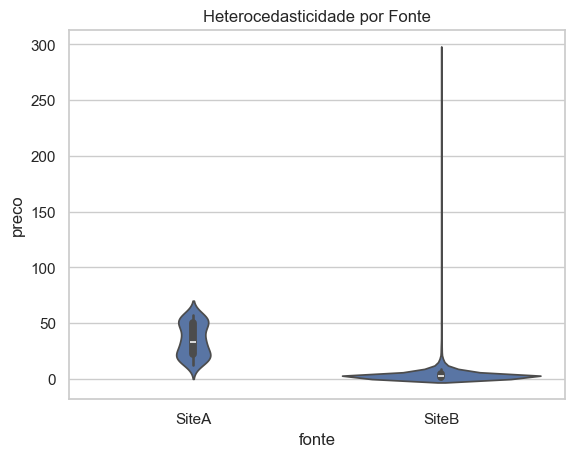

Teste Levene: 87.18447686420728, p-value: 1.5477297998018433e-20


ValueError: 
    Invalid element(s) received for the 'size' property of scattergl.marker
        Invalid elements include: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

    The 'size' property is a number and may be specified as:
      - An int or float in the interval [0, inf]
      - A tuple, list, or one-dimensional numpy array of the above

In [3]:
# Célula 1: Importações e Carga de Dados
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import plotly.express as px
from wordcloud import WordCloud
import folium
from folium.plugins import HeatMap

dados = pd.read_csv('dados_integrados_preprocessados.csv')
sns.set(style='whitegrid')

# 1. Distribuição principal (histograma + KDE) de preços
plt.figure(figsize=(10,6))
sns.histplot(dados['preco'], kde=True)
plt.title('Distribuição Principal dos Preços')
plt.show()

# 2. Diferenças estatisticamente significativas entre fontes (boxplots + testes)
plt.figure(figsize=(10,6))
sns.boxplot(data=dados, x='fonte', y='preco')
plt.title('Diferenças de Preços por Fonte')
plt.show()
# Teste t (exemplo)
group_a = dados[dados['fonte']=='SiteA']['preco']
group_b = dados[dados['fonte']=='SiteB']['preco']
t_stat, p_val = stats.ttest_ind(group_a, group_b)
print(f'Teste t: {t_stat}, p-value: {p_val}')

# 3. Comportamento ao longo do tempo (se houver datas; assumindo adição futura)
# Se não houver 'data', pule ou simule. Exemplo com decomposição:
# dados['data'] = pd.date_range(start='1/1/2023', periods=len(dados))  # Simulação
# ts = dados.set_index('data')['preco']
# decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=30)
# decomposition.plot()
# plt.show()

# 4. Relação não-linear entre preço e avaliação (scatter + lowess)
plt.figure(figsize=(10,6))
sns.regplot(x='preco', y='avaliacao', data=dados, lowess=True)
plt.title('Relação Não-Linear: Preço vs Avaliação')
plt.show()

# 5. Clusters naturais (PCA + scatter colorido por cluster)
pca = PCA(n_components=2)
reduced = pca.fit_transform(dados[['preco', 'avaliacao']].fillna(0))
kmeans = KMeans(n_clusters=3)
dados['cluster'] = kmeans.fit_predict(reduced)
px.scatter(dados, x=reduced[:,0], y=reduced[:,1], color='cluster').show()

# 6. Outliers multivariados (Mahalanobis + boxplots)
from scipy.spatial.distance import mahalanobis
cov = dados[['preco', 'avaliacao']].cov().values
mean = dados[['preco', 'avaliacao']].mean().values
dados['mahalanobis'] = dados.apply(lambda row: mahalanobis([row['preco'], row['avaliacao']], mean, cov), axis=1)
outliers = dados[dados['mahalanobis'] > 3]  # Threshold
sns.boxplot(data=dados, y='preco')
plt.scatter(outliers.index, outliers['preco'], color='red')
plt.title('Outliers em Preços')
plt.show()

# 7. Correlação entre variáveis (heatmap com clustering)
corr = dados[['preco', 'avaliacao']].corr()
sns.clustermap(corr, annot=True, cmap='coolwarm')
plt.title('Heatmap de Correlação')
plt.show()

# 8. Heterocedasticidade (violin plots + testes)
sns.violinplot(data=dados, x='fonte', y='preco')
plt.title('Heterocedasticidade por Fonte')
plt.show()
# Teste Levene
stat, p = stats.levene(group_a, group_b)
print(f'Teste Levene: {stat}, p-value: {p}')

# 9. Segmentos com melhor custo-benefício (bubble chart)
dados['custo_beneficio'] = dados['avaliacao'] / dados['preco']
px.scatter(dados, x='preco', y='avaliacao', size='custo_beneficio', color='fonte', hover_name='nome').show()

# 10. Elasticidade (regressões locais)
# Exemplo simples com regressão linear local
from sklearn.linear_model import LinearRegression
X = dados[['preco']].values
y = dados['avaliacao'].values  # Assumindo 'volume' como avaliacao placeholder
model = LinearRegression()
model.fit(X, y)
px.scatter(dados, x='preco', y='avaliacao', trendline='ols').show()

# 11. Distribuição condicional por subgrupos (faceted plots)
g = sns.FacetGrid(dados, col='fonte')
g.map(sns.histplot, 'preco', kde=True)
plt.show()

# 12. Features mais importantes (permutation importance)
X = dados[['preco', 'avaliacao']]  # Adicione mais se houver
y = dados['preco']  # Alvo exemplo
rf = RandomForestRegressor()
rf.fit(X, y)
perm = permutation_importance(rf, X, y)
px.bar(x=X.columns, y=perm.importances_mean).show()

# 13. Padrões geoespaciais (se houver coords; simule ou pule)
# Exemplo com folium se adicionar lat/long
m = folium.Map(location=[0,0], zoom_start=2)
HeatMap([[0,0]]).add_to(m)  # Placeholder
m.save('mapa.html')

# 14. Evolução de reviews e tópicos (wordcloud; assumindo texto em 'nome')
text = ' '.join(dados['nome'])
wc = WordCloud().generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# 15. Agregação temporal (se houver datas; comparando plots)
# Simulação: dados['mes'] = pd.date_range(start='1/1/2023', periods=len(dados)).month
# sns.lineplot(data=dados.groupby('mes')['preco'].mean(), label='Mensal')
# sns.lineplot(data=dados.groupby(pd.Grouper(key='data', freq='W'))['preco'].mean(), label='Semanal')
# plt.show()